# Binary Classification

As a clothing retailer with an e-Commerce presence, it's important for us to understand what customers are saying about our products, which products are most popular with our customers, and how we can improve our offerings.

**Recommendation Prediction**: We will use the text from customer reviewsto understand better if a customer will give a positive rating on the clothing items based on their review.

In [1]:
import numpy as np
import pandas as pd
import itertools
import string
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# NLTK Imports and Downloads
import nltk
from nltk.sentiment.util import *
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing & EDA

Importing our dataset and providing the necessary cleaning and analysis.

In [2]:
df = pd.read_csv("ClothingReviews.csv")
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Tops,Blouses


In [3]:
# add a column for positive or negative
df['Target'] = df['Rating'].apply(lambda c: 0 if c < 4 else 1)

## Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      23486 non-null  int64 
 1   Title                    19676 non-null  object
 2   Review Text              22641 non-null  object
 3   Rating                   23486 non-null  int64 
 4   Recommended IND          23486 non-null  int64 
 5   Positive Feedback Count  23486 non-null  int64 
 6   Department Name          23472 non-null  object
 7   Class Name               23472 non-null  object
 8   Target                   23486 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 1.6+ MB


In [5]:
df.shape

(23486, 9)

### Null Values

Nulll values are generally not desireable in a dataset.  In certain cases, observations (rows) with low counts will simply be dropped, in other cases, they can be filled with other values.

In [6]:
# fill the NA values with 0
df['Title'].fillna('', inplace=True)

In [7]:
# count of nulls
df.isnull().sum()

Age                          0
Title                        0
Review Text                845
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Department Name             14
Class Name                  14
Target                       0
dtype: int64

In [8]:
df.dropna(inplace=True)

**Note**: The null values for the lower counts (except `Title`) were dropped from the dataset.

In [9]:
df['Text'] = df['Title'] + ' ' + df['Review Text']

In [10]:
# Add column 'text_len' that counts the length for the derived field
df['text_len'] = df.apply(lambda row: len(row['Text']), axis = 1)

In [11]:
df.drop(columns=['Title', 'Review Text'], inplace=True)

### Duplicates

A common practice is to review any duplicates.  If there are large quantities, they can skew the results.

In [12]:
len_before = df.shape[0]
df.drop_duplicates(inplace=True)
len_after = df.shape[0]

print("Before =", len_before)
# drop duplicates
print("After =", len_after)
print('')
print("Total Removed =", len_before - len_after)

Before = 22628
After = 22626

Total Removed = 2


## EDA

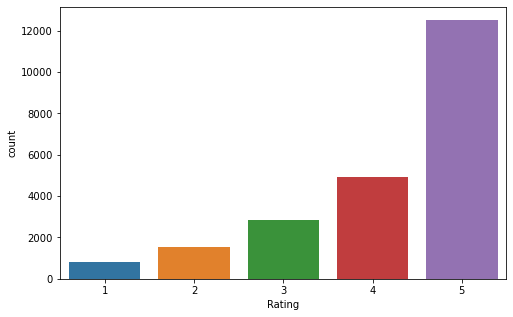

In [32]:
plt.figure(figsize=(8,5))
sns.countplot(x='Rating', data=df);

## Text Cleaning

For **Parts** of our analysis, the text needs to have some basic transformation for our models to work propertly.  These are as follows:

1. **Lower**: Convert all characters to lowercase
1. **Remove Punctuation**: In most cases, punctuation doesn't help NLP and ML models and can be removed.
1. **Stop Word Removal**: Stop words generally don't add context to analysis (unless the length of text is very short (`100` - `200` characters) and can be removed.
1. **Lemmatization**: Words will be reduced to there *Lemma* or root.  This will greatly improve the accuracy of the analysis since words like `simming` and `swimmer` will be reduced to `swim`.

**Note**: The orginal text will be preserved for other analysis.

In [14]:
df['Text'][2]

'Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [15]:
def process_string(text, stem="None"):
    
    final_string = ""
    
    text = text.lower()
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)
    useless_words = useless_words + ['.', ',', '!', "'"]
    text_filtered = [word for word in text if not word in useless_words]
    
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered
    
    for word in text_stemmed:
        final_string += word + " "
    
    return final_string

In [16]:
df['Text_Processed'] = df['Text'].apply(lambda x: process_string(x, stem='Lem'))

In [17]:
df['Text_Processed'][2]

'major design flaw high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c '

# Sentiment Based Prediction Model:

Next, we'll create a Supervised ML model to predict whether a customer will recommend a product based on the text from the review and the sentiment of that text, and the length of the review.

To create our model, we will be mixing both text and numeric values.  There are multiple ways to accomplish this, but we will be using a `ColumnTransformer` in a Pipeline.

## Model Selection

In [18]:
X = df[['Text', 'text_len']]
y = df['Target']

In [19]:
print(X.shape)
print(y.shape)

(22626, 2)
(22626,)


In [20]:
def col_trans():
    column_trans = ColumnTransformer(
            [('Text', TfidfVectorizer(stop_words='english'), 'Text'),
             ('Text Length', MinMaxScaler(), ['text_len'])],
            remainder='drop') 
    
    return column_trans

In [21]:
def create_pipe(clf):
    '''Create a pipeline for a given classifier.  The classifier needs to be an instance
    of the classifier with all parmeters needed specified.'''
    
    # Each pipeline uses the same column transformer.  
    column_trans = col_trans()
    
    pipeline = Pipeline([('prep',column_trans),
                         ('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
     
    return pipeline

In [22]:
models = {'LogReg' : LogisticRegression(random_state=42, 
                                        class_weight='balanced', 
                                        max_iter=500),
          'RandomForest' : RandomForestClassifier(class_weight='balanced', 
                                                  random_state=42)}

for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    cv = RepeatedStratifiedKFold(n_splits=10, 
                                 n_repeats=3, 
                                 random_state=1)
    scores = cross_val_score(pipeline, X, y, 
                             scoring='f1_macro', cv=cv, 
                             n_jobs=-1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

LogReg : Mean f1 Macro: 0.840 and Standard Deviation: (0.007)
RandomForest : Mean f1 Macro: 0.798 and Standard Deviation: (0.008)


**Observations**:

The **Support Vector Machine** Classifier performed the best with the **Random Forest** and **Logistic Regression** behind it.  Complement Naive Bayes performed the worst. 

`SVC` is a fairly computationally expensive algorithm [5]; it might be advantageous to use **Logistic Regression** if performance were top priority.

## Model Building

In [23]:
# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=53)

In [24]:
print(y_train.shape)
print(X_train.shape)

(15159,)
(15159, 2)


## Model Validation

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [26]:
def fit_and_print(pipeline, name):
    ''' take a supplied pipeline and run it against the train-test spit 
    and product scoring results.'''
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred, average='macro')

    print(metrics.classification_report(y_test, y_pred, digits=3))

    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, classes=[0,1])

              precision    recall  f1-score   support

           0      0.707     0.824     0.761      1715
           1      0.945     0.898     0.921      5752

    accuracy                          0.881      7467
   macro avg      0.826     0.861     0.841      7467
weighted avg      0.890     0.881     0.884      7467

Confusion matrix, without normalization


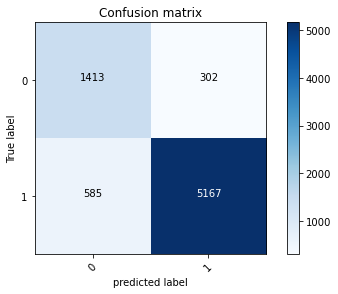

In [27]:
clf = LogisticRegression(random_state=42, 
                         class_weight='balanced', 
                         max_iter=500)
pipeline = create_pipe(clf)
fit_and_print(pipeline, 'Logistic Regression')

**Observations**:

This model performed extremely well across our dataset with an `f1 macro` score of `0.915`.  The dataset has imbalanced, which was corrected for SMOTE (Over Sampling combined with Undersampling).  The result was a very strong predictor model based on `text`, `sentiment`, and `text_len`.

## Test on Custom Data

In [28]:
def create_test_data(x):
    '''calculate the numbers needed to run on custom data including sentiment and text length,
    this is a farily simple process using the fuctions from previous transformations.'''
    
    x = process_string(x)
    length = len(x)
    
    d = {'Text' : x,
        'text_len' : length}

    df = pd.DataFrame(d, index=[0])
    
    return df

In [29]:
revs = ['This dress is gorgeous and I love it and would gladly reccomend it to all of my friends.',
        'This skirt has really horible quality and I hate it!',
        'A super cute top with the perfect fit.',
        'The most gorgeous pair of jeans I have seen.',
        'this item is too little and tight.']

In [30]:
print('The classifier will return 1 for Positive reviews and 0 for Negative reviews:','\n')
for rev in revs:
    c_res = pipeline.predict(create_test_data(rev))
    print(rev, '=', c_res)

The classifier will return 1 for Positive reviews and 0 for Negative reviews: 

This dress is gorgeous and I love it and would gladly reccomend it to all of my friends. = [1]
This skirt has really horible quality and I hate it! = [0]
A super cute top with the perfect fit. = [1]
The most gorgeous pair of jeans I have seen. = [1]
this item is too little and tight. = [0]
